In [133]:
%run ../modules.ipynb
sys.path.append('../0. kernel-tutorials/')
# Local Utilities for Notebook
from utilities.kernels import linear_kernel, gaussian_kernel
from utilities.general import load_variables, get_stats
from utilities.plotting import (
    plot_base, 
    plot_projection,
    plot_regression,
    plot_simple,
    get_cmaps,
    table_from_dict,
    check_mirrors,
)
cmaps = get_cmaps()
plt.style.use("../0. kernel-tutorials/utilities/kernel_pcovr.mplstyle")
dbl_fig = (2 * plt.rcParams["figure.figsize"][0], plt.rcParams["figure.figsize"][1])

kernel_params = {"kernel": "rbf", "gamma": 1}
kernel_func = partial(rbf_kernel, gamma=1)
kernel_type = "gaussian"


../0. kernel-tutorials/utilities/colorbars.py:19: UserWarning: Trying to register the cmap 'cbarHot' which already exists.
  plt.register_cmap(cmap=self.cbar)
../0. kernel-tutorials/utilities/colorbars.py:19: UserWarning: Trying to register the cmap 'cbarBWR' which already exists.
  plt.register_cmap(cmap=self.cbar)
../0. kernel-tutorials/utilities/colorbars.py:35: UserWarning: Trying to register the cmap 'cbarPhi' which already exists.
  plt.register_cmap(cmap=self.cbar)
../0. kernel-tutorials/utilities/colorbars.py:19: UserWarning: Trying to register the cmap 'cbarHot_0.3_1.05' which already exists.
  plt.register_cmap(cmap=self.cbar)
../0. kernel-tutorials/utilities/colorbars.py:19: UserWarning: Trying to register the cmap 'bone_r_0.2_1.0' which already exists.
  plt.register_cmap(cmap=self.cbar)
../0. kernel-tutorials/utilities/colorbars.py:19: UserWarning: Trying to register the cmap 'Reds_0.3_1.0' which already exists.
  plt.register_cmap(cmap=self.cbar)
../0. kernel-tutorials/ut

In [134]:
"""The file has been created in zip format, reading it"""

frames_init_tot=ase.io.read('MP_complete_init.xyz', index=':')
frames_relax_tot=ase.io.read('MP_complete_relax.xyz', index=':')

zf = zipfile.ZipFile('./MP_complete.zip') 
df_csv = pd.read_csv(zf.open('MP_complete.csv'))

natoms_list_tot=[]
for i in range(len(df_csv)):
    natoms_list_tot.append(natoms(df_csv['structure'][i]))

len(formE_tot), len(frames_init_tot), len(frames_relax_tot), len(natoms_list_tot)

(83989, 83989, 83989, 83989)

In [135]:
select=2000
formE, gap, hull, frames_init, frames_relax, natoms_list = zip(*random.sample(list(zip(formE_tot, gap_tot, hull_tot, frames_init_tot, frames_relax_tot, natoms_list_tot)), select))
len(formE),len(hull), len(frames_init), len(frames_relax), len(natoms_list)

frames=[]
for frame in frames_init:
    frame.wrap(eps=1e-12)
    frames.append(frame)

In [136]:
soap = SOAP(soap_type='PowerSpectrum',
           interaction_cutoff=3.5,
           max_radial=5,
           max_angular=5,
           gaussian_sigma_type='Constant',
           gaussian_sigma_constant=0.3,
           cutoff_smooth_width=0.5, 
           normalize=True)

In [137]:
soap_rep= soap.transform(frames)
X_raw = soap_rep.get_features(soap)
n_FPS=70
col_idxs = FPS(n_features_to_select=n_FPS).fit(X_raw).selected_idx_
Xraw = X_raw[:, col_idxs]
X.shape

(1500, 50)

In [85]:
# """Sparse methods"""

# # # %whos 
# select1=300
# # #LANDMARK SET
# frames_ase_random=random.sample(frames, select1)
# soap_rep= soap.transform(frames_ase_random)
# soap_rep

# # %whos 
# Xsparse = soap_rep.get_features(soap)
# col_idxs = FPS(n_features_to_select=n_FPS).fit(Xsparse).selected_idx_
# Xsparse = Xsparse[:, col_idxs]
# Xsparse.shape, max(col_idxs)

# Xsparse_tot=[]

# step=100
# for i in range(0, len(frames), step):
#     soap_rep= soap.transform(frames[i:i+step])
#     Xsp = soap_rep.get_features(soap)
# #     print(Xsp.shape)
#     z=[ [0] * (max(col_idxs)-len(Xsp[0])+1) for _ in range(len(Xsp))]
#     z=np.asarray(z)
#     Xsp=np.append(Xsp, z, axis=1)
# #     print(Xsp.shape)
#     Xsp = Xsp[:, col_idxs]
#     print(Xsp.shape)
#     Xsparse_tot.append(Xsp)
    
# Xrest=np.concatenate(Xsparse_tot)
# Xrest.shape

# # for obj in locals().values():
# #     print (sys.getsizeof(obj)) 
# # import sys

# # local_vars = list(locals().items())
# # for var, obj in local_vars:
# #     print(var, sys.getsizeof(obj))

In [138]:
soap_cumul=np.zeros((len(natoms_list), n_FPS))
start=0
for i in range(len(natoms_list)):
    natoms=natoms_list[i]
    soap_cumul[i]=np.mean(Xraw[start:int(start+natoms)], axis=0)
    start=start+natoms

to_predict=np.asarray(formE) 
to_predict=to_predict.reshape((-1,1))

print("soap cumulative shape is:"+ str(soap_cumul.shape))
print("E shape is:"+ str(to_predict.shape))

soap_cumul.shape, (to_predict.shape)


soap cumulative shape is:(2000, 70)
E shape is:(2000, 1)


((2000, 70), (2000, 1))

In [139]:
X=np.copy(soap_cumul)
Y=np.copy(to_predict)
X.shape, Y.shape

((2000, 70), (2000, 1))

In [140]:
n_train = int(len(Y)/2)
n_test = len(Y)-n_train
r_train = np.asarray(range(len(Y)))
i_train, i_test = train_test_split(r_train, train_size=n_train, shuffle=True)

X_train = X[i_train]
Y_train = Y[i_train]
X_test = X[i_test]
Y_test = Y[i_test]

print(f'Shape of testing data is: {X_train.shape}, ||X|| = {np.linalg.norm(X_train)}.')
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)


print(
    "Norm of the features: %0.2f \nNorm of the targets: %0.2f"
    % (np.linalg.norm(X), np.linalg.norm(Y))
)
x_scaler = StandardFlexibleScaler(column_wise=False).fit(X_train)
y_scaler = StandardFlexibleScaler(column_wise=True).fit(Y_train)

# Center total dataset
X = x_scaler.transform(X)
Y = y_scaler.transform(Y)

# Center training data
X_train = x_scaler.transform(X_train)
Y_train = y_scaler.transform(Y_train)

# Center training data
X_test = x_scaler.transform(X_test)
Y_test = y_scaler.transform(Y_test)

Shape of testing data is: (1000, 70), ||X|| = 17.917758191830345.
(1000, 70) (1000, 70) (1000, 1) (1000, 1)
Norm of the features: 25.02 
Norm of the targets: 87.34


In [141]:
alphas=np.logspace(-0, -6, 30)

R^2 of training is  0.0737370079321
R^2 of testing is  -0.0797275995272
Best regularization is  1.0


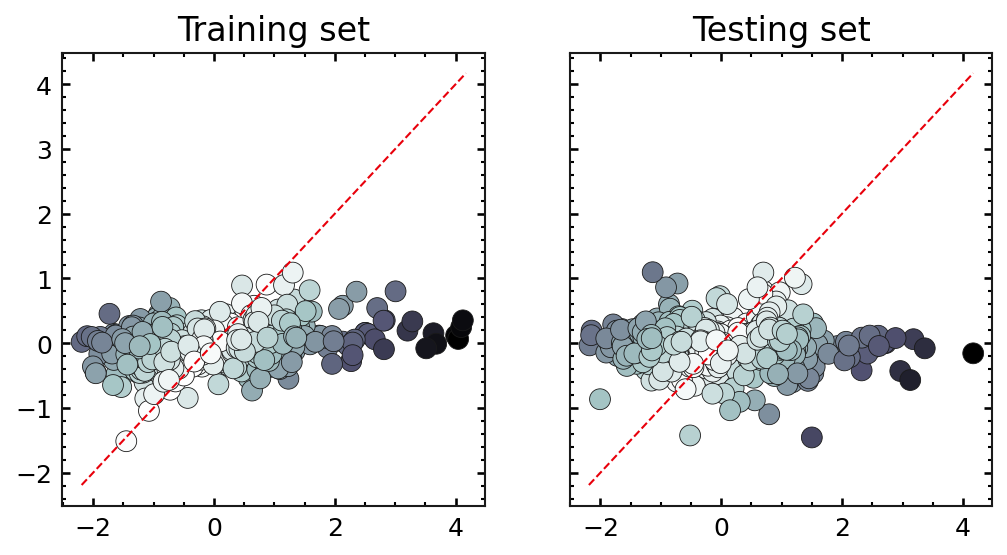

In [142]:
ridge = RidgeCV(cv=2,fit_intercept=False, alphas=alphas)
ridge.fit(X_train, Y_train)
yp_test=ridge.predict(X_test)
yp_train=ridge.predict(X_train)
print('R^2 of training is ', ridge.score(X_train,Y_train))
print('R^2 of testing is ', ridge.score(X_test,Y_test))
print('Best regularization is ', ridge.alpha_)
fig, (ax_train, ax_test)=plt.subplots(1,2,figsize=(8,4), sharex=True, sharey=True)
ax_train.scatter(Y_train, yp_train, c=np.abs(Y_train - yp_train), cmap="bone_r", ec="k")
ax_test.scatter(Y_test, yp_test, c=np.abs(Y_test - yp_test), cmap="bone_r", ec="k")

bounds=(np.min((Y.min(), yp_train.min(), yp_test.min())), 
       np.max((Y.max(), yp_train.max(), yp_test.max()))
       )

ax_train.plot(bounds,bounds, 'r--')
ax_train.set_title('Training set')
ax_test.set_title('Testing set')
ax_test.plot(bounds,bounds, 'r--')

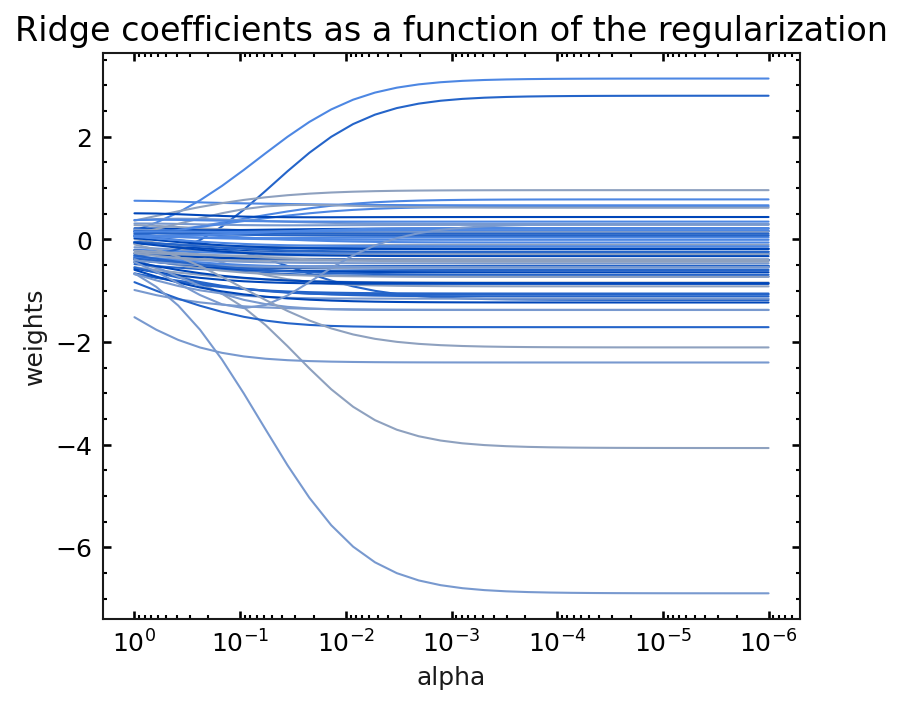

In [143]:
coefs = []
for a in alphas:
    ridge = Ridge(alpha=a,fit_intercept=False)
    ridge.fit(X_train, Y_train)
    Y_pred=ridge.predict(X_test)
#     print(ridge.score(X_test, Y_test))
    coefs.append(ridge.coef_.ravel())
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()


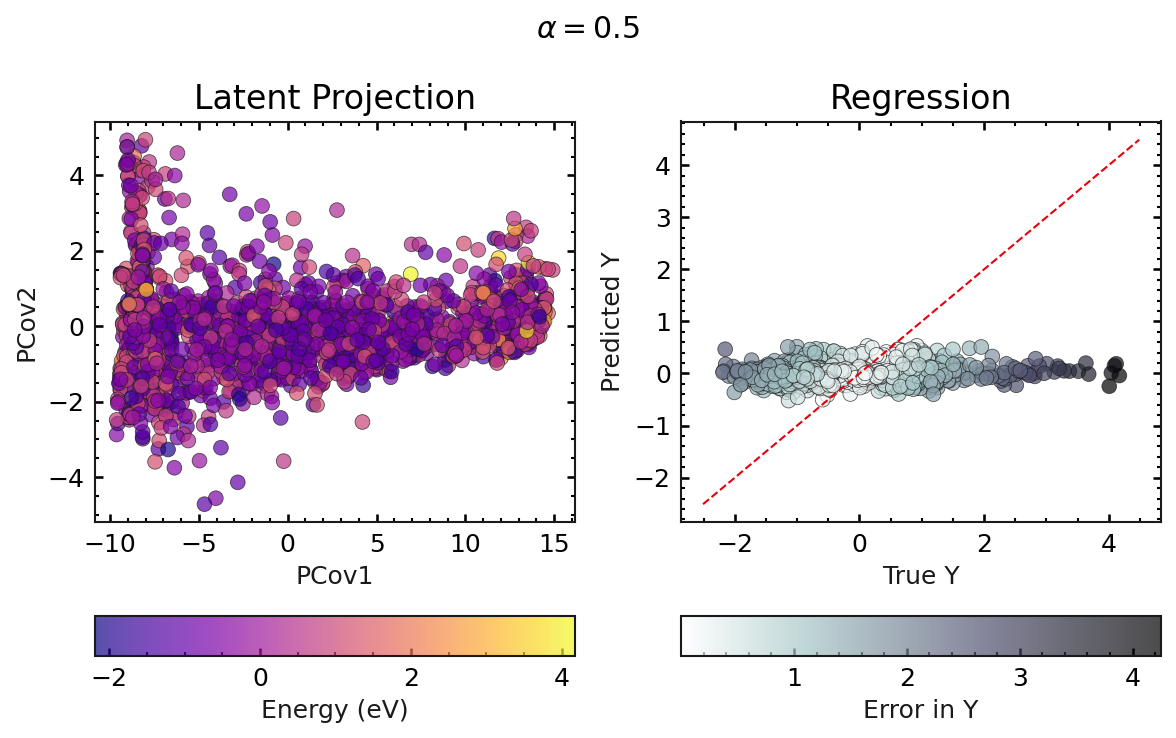

In [144]:
mixing = 0.5
pcovr = PCovR(mixing=mixing,
              n_components=2 )
pcovr.fit(X,Y)
T = pcovr.transform(X)
yp = pcovr.predict(X)

fig, ((axT, axy), (caxT, caxy)) = plt.subplots(
    2, 2, figsize=(8, 5), gridspec_kw=dict(height_ratios=(1, 0.1))
)

scatT = axT.scatter(T[:, 0], T[:, 1], s=50, alpha=0.7, c=Y, cmap='plasma', edgecolor="k")
axT.set_xlabel("PCov1")
axT.set_ylabel("PCov2")
axT.set_title("Latent Projection")
fig.colorbar(scatT, cax=caxT, label="Energy (eV)", orientation="horizontal")

scaty = axy.scatter(Y, yp, s=50, alpha=0.7, c=np.abs(Y - yp), cmap='bone_r', edgecolor="k")
axy.plot(axy.get_xlim(), axy.get_xlim(), 'r--')
fig.suptitle(r"$\alpha=$" + str(mixing))

axy.set_xlabel(r"True Y")
axy.set_ylabel(r"Predicted Y")
axy.set_title("Regression")
fig.colorbar(scaty, cax=caxy, label="Error in Y", orientation="horizontal")

fig.tight_layout()

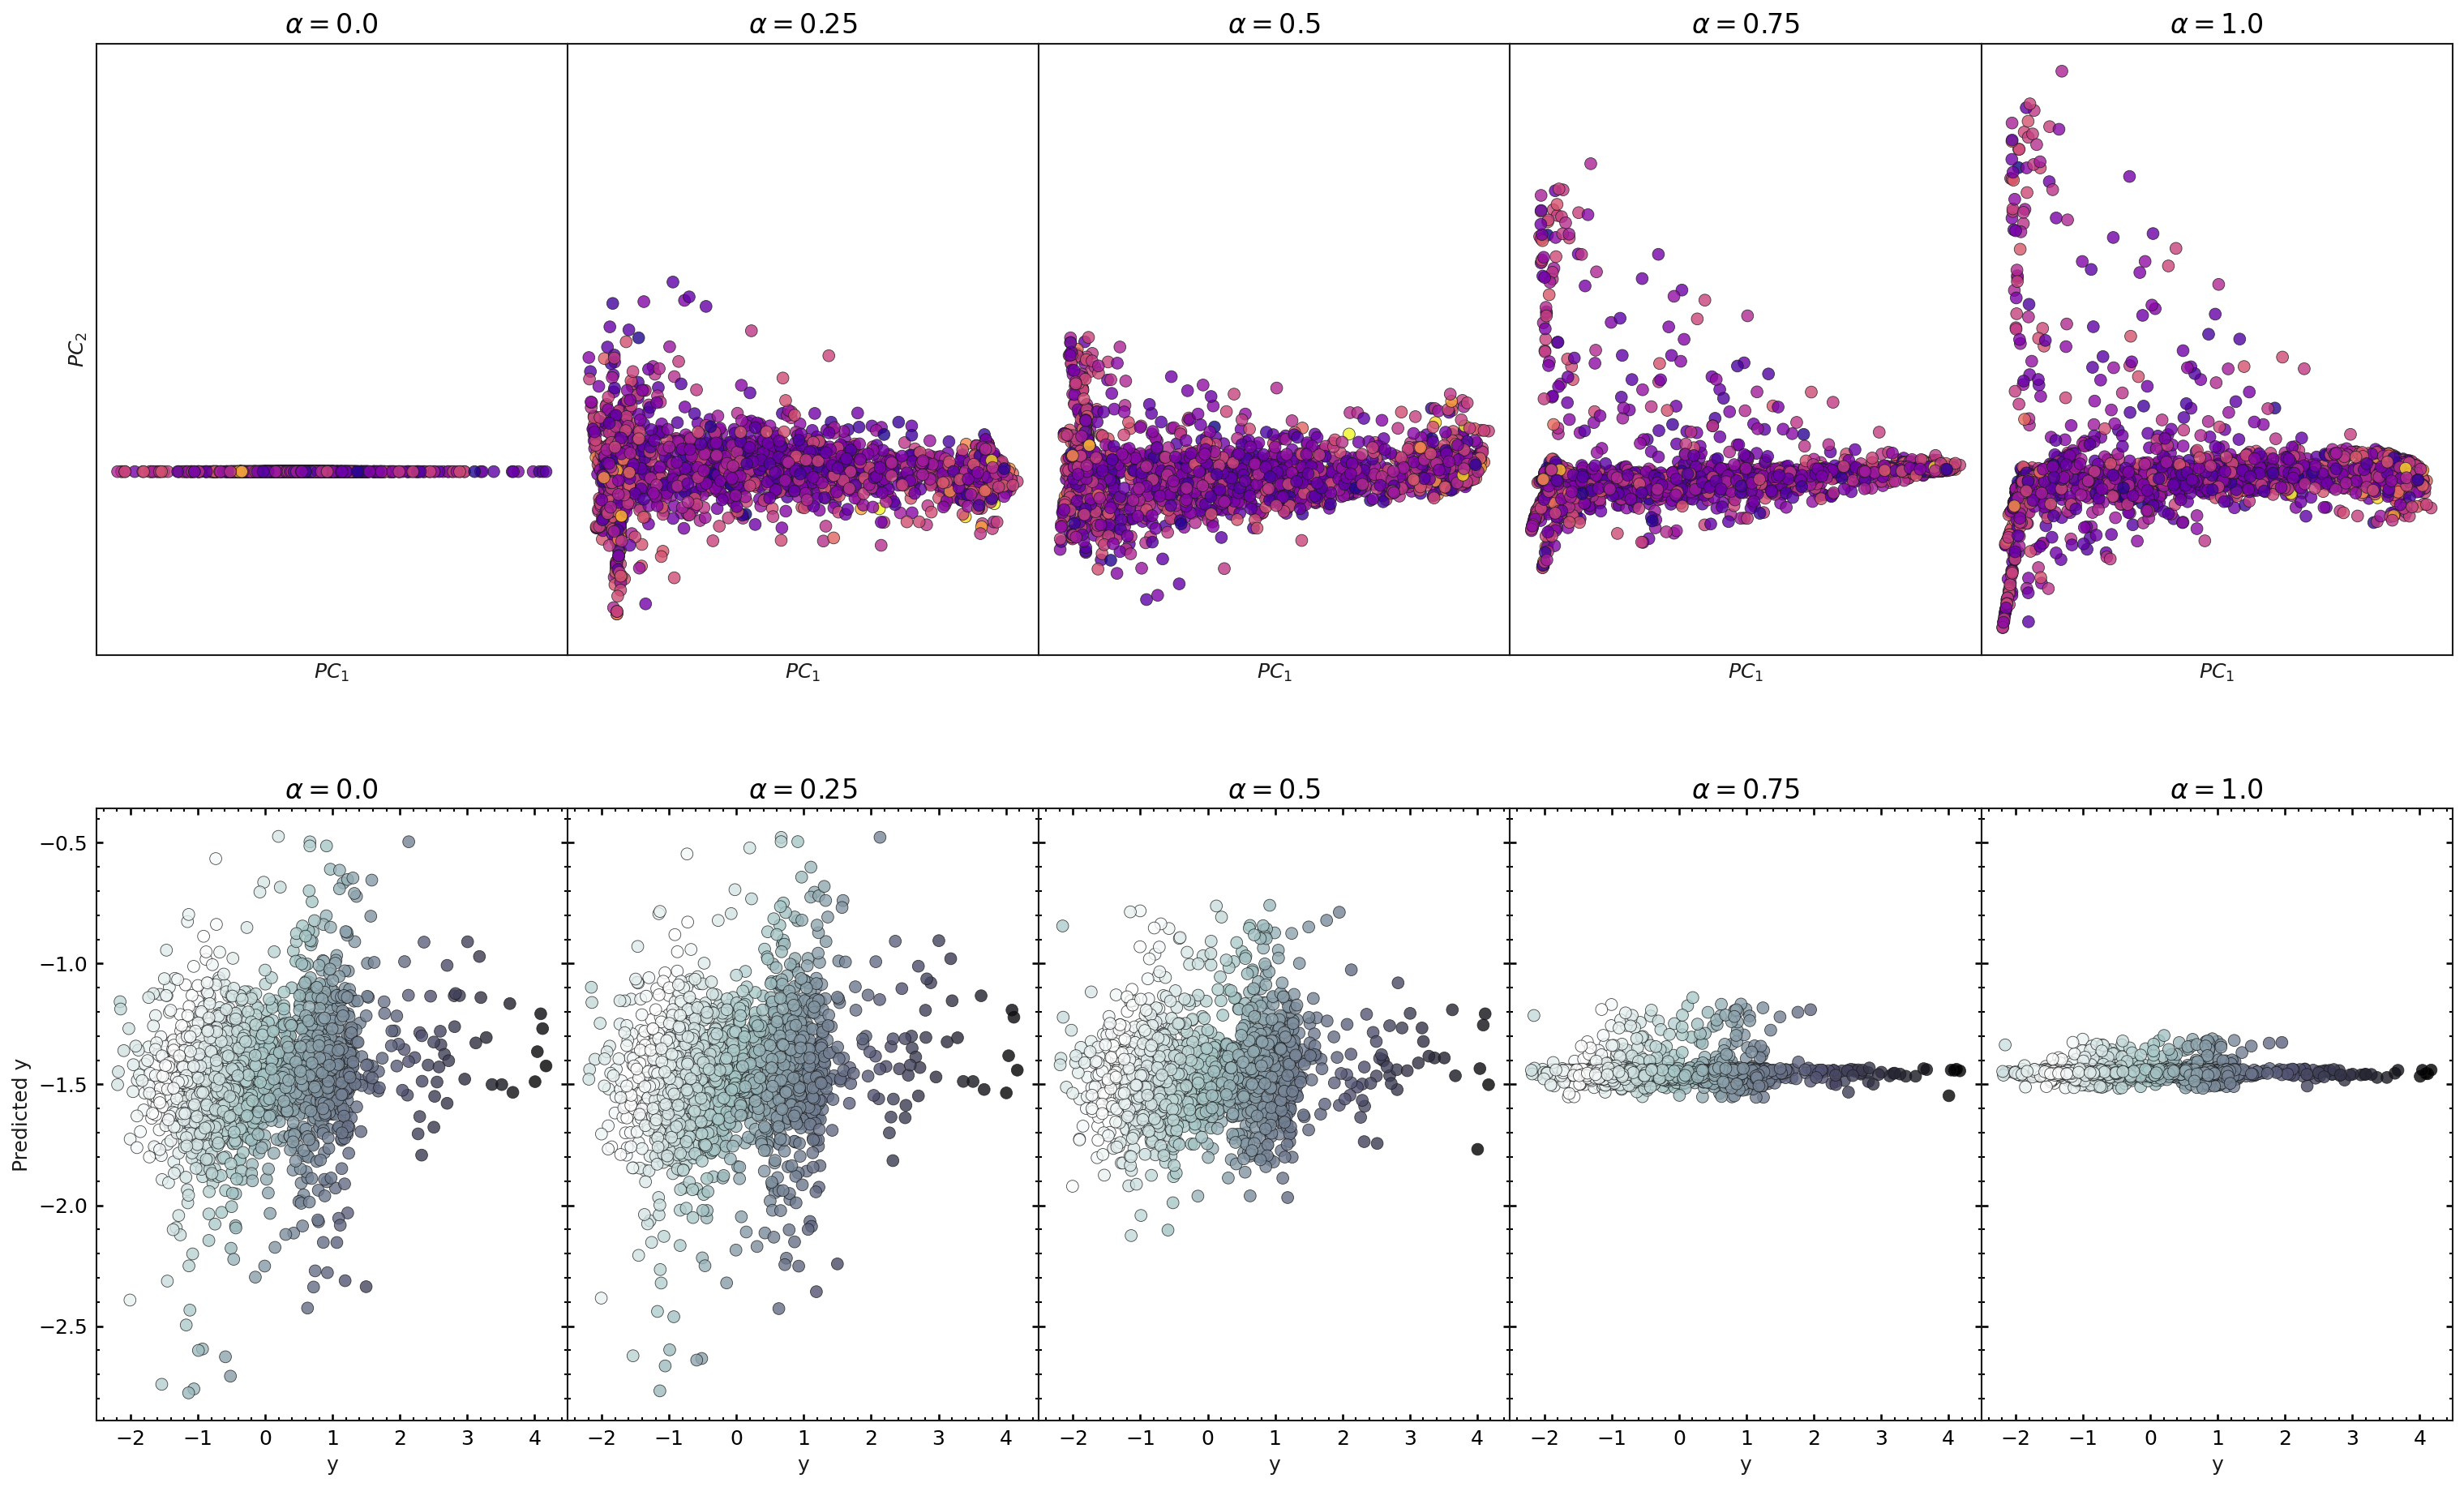

In [145]:
n_alpha = 5

fig, axes = plt.subplots(2, n_alpha, 
                         figsize=(5*n_alpha, 15),
                         sharey='row'
                        )

for i, mixing in enumerate(np.linspace(0, 1, n_alpha)):
    

    pcovr = PCovR(mixing=mixing, 
                      n_components=2, )
    pcovr.fit(X, Y)
    T = pcovr.transform(X)
    yp = y_scaler.inverse_transform(pcovr.predict(X))

    axes[0, i].scatter(T[:, 0], 
                       T[:, 1], 
                       s=50, 
                       alpha=0.8,
                       c=Y, 
                       cmap='plasma',  
                       edgecolor='k'
                      )
    axes[0,i].set_title(r"$\alpha=$" + str(mixing))
    axes[0,i].set_xlabel(r"$PC_1$")
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])

    axes[1, i].scatter(Y, 
                       yp, 
                       s=50, 
                       alpha=0.8,
                       c=np.abs(Y-yp), 
                       cmap='bone_r', 
                       edgecolor='k')
    axes[1,i].set_title(r"$\alpha=$" + str(mixing))
    axes[1,i].set_xlabel("y")
    
axes[0,0].set_ylabel(r"$PC_2$")
axes[1,0].set_ylabel("Predicted y")

fig.subplots_adjust(wspace=0, hspace=0.25)
plt.show()

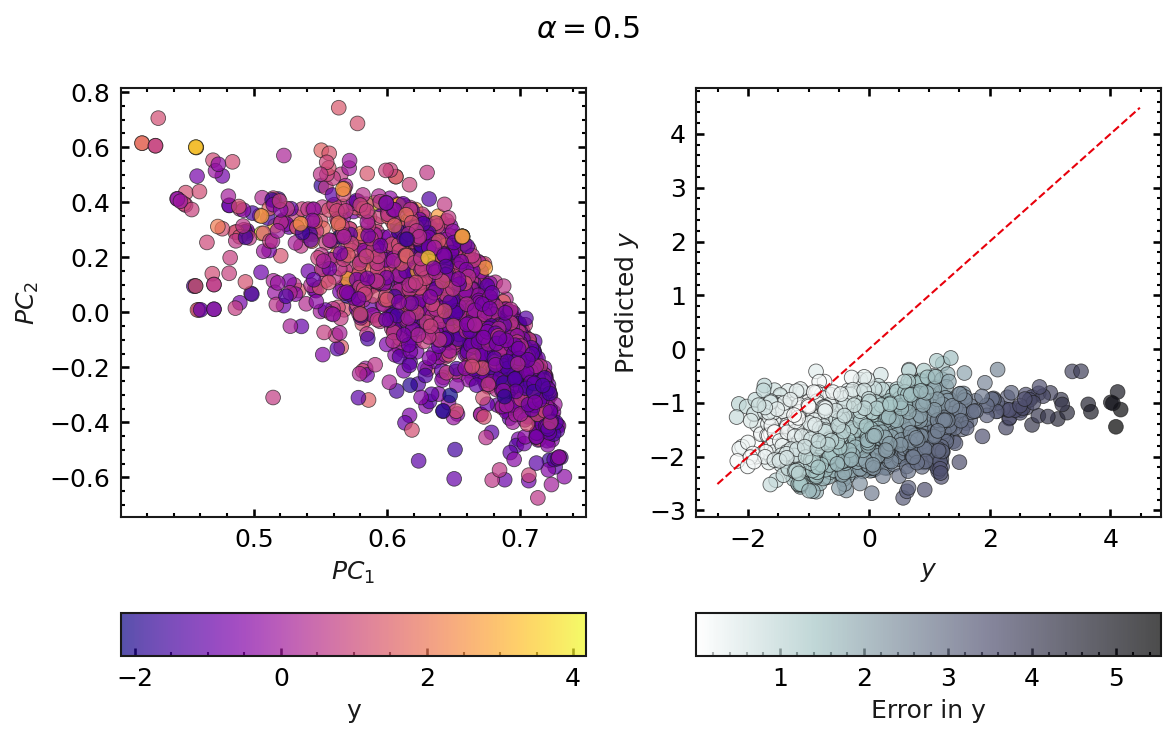

In [146]:
mixing = 0.5
kpcovr = KPCovR(
    mixing=mixing,
    alpha=1e-4,
    kernel="rbf",
    gamma=0.1,
    n_components=2,
)
kpcovr.fit(X, Y)
T = kpcovr.transform(X)
yp = y_scaler.inverse_transform(kpcovr.predict(X))

fig, ((axT, axy), (caxT, caxy)) = plt.subplots(
    2, 2, figsize=(8, 5), gridspec_kw=dict(height_ratios=(1, 0.1))
)

scatT = axT.scatter(T[:, 0], T[:, 1], s=50, alpha=0.7, c=Y, cmap='plasma', edgecolor="k")
axT.set_xlabel(r"$PC_1$")
axT.set_ylabel(r"$PC_2$")
fig.colorbar(scatT, cax=caxT, label="y", orientation="horizontal")

scaty = axy.scatter(Y, yp, s=50, alpha=0.7, c=np.abs(Y - yp), cmap='bone_r', edgecolor="k")
axy.plot(axy.get_xlim(), axy.get_xlim(), "r--")
fig.suptitle(r"$\alpha=$" + str(mixing))

axy.set_xlabel(r"$y$")
axy.set_ylabel(r"Predicted $y$")
fig.colorbar(scaty, cax=caxy, label="Error in y", orientation="horizontal")

fig.tight_layout()